## A simple walkthrough on how we can leverage anomaly detection algos to detect fraudulent transactions. 

Companies capture a high dimension of behavioural data on transactions. As such, without indepth domain knowledge, formulating risk rules to identify anomalies in network traffic is challenging. However, we can leverage unsupervised Machine Learning techniques to create a list of anomalies which can then be fed into an auditing process which then generates the true labels. 

This notebook aims to compare various unsupervised algorithms. For this I use a labelled dataset. But the algorithms do not see the labels while training. The labels are only used to compare the model predictions to the actual values and to create performance metrics.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.preprocessing import LabelEncoder

import h2o
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, confusion_matrix, log_loss, accuracy_score

#settings
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
seed = 123

/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
# load cleaned dataframe
with open('../../data/df1.pkl', 'rb') as read_file:
    df1 = pickle.load(read_file)

In [3]:
df1.head(3)

,PspReference,CompanyAccount,MerchantAccount,PaymentCreationDate,Response,Refused,CurrencyCode,Amount,Scheme,PaymentMethodVariant,IssuerCountryCode,ShopperCountryCode,Bin,3DSecureAttempt,FirstThreeDigits_Bin,FirstTwoDigits_Bin,FirstDigit_Bin,Year,Month,DateOnly,DayOfWeek,Hour,MerchantCountryCode,Response_int,PaymentMethod,PaymentType,Date,Hour_category,Amt_bins,Amt_quintiles,Amt
0,psp:42337421583943072,ABCLimited,ABC_IDR,2017-10-01 06:00:00,FRAUD,1,IDR,1000.00,visa,standarddebit,ID,ID,409766,No,409,40,4,2017,10,2017-10-01,7,6,ID,1,debit,visadebit,10-01,1,"(900.0, 2000.0]","(500.0, 1000.0]",0.09
1,psp:5575421173125505,XYZLimited,XYZ_SGD,2017-10-01 06:00:00,APPROVED,0,SGD,10000.00,mastercard,superpremiumcredit,SG,SG,522274,Yes,522,52,5,2017,10,2017-10-01,7,6,SG,0,credit,mastercardcredit,10-01,1,"(7300.0, 600000.0]","(2500.0, 10000.0]",10000.00
2,psp:62997268047183752,ABCLimited,ABC_IDR,2017-10-01 06:01:00,APPROVED,0,IDR,20000.00,visa,standarddebit,ID,ID,466160,No,466,46,4,2017,10,2017-10-01,7,6,ID,0,debit,visadebit,10-01,1,"(7300.0, 600000.0]","(10000.0, 600000.0]",1.84


In [4]:
df1.Response.value_counts()

APPROVED                     57166
FRAUD                        4980 
DECLINED                     1789 
NOT_3D_AUTHENTICATED         328  
CVC_DECLINED                 87   
NOT_ENOUGH_BALANCE           60   
CARD_EXPIRED                 24   
TRANSACTION_NOT_PERMITTED    23   
INVALID_CARD                 13   
ISSUER_UNAVAILABLE           8    
ERROR                        7    
BLOCK_CARD                   4    
UNKNOWN                      3    
Name: Response, dtype: int64

In [5]:
# convert `response` that are not approved or fraud to others 
df1.Response_int.value_counts()

0    57166
1    4980 
2    2346 
Name: Response_int, dtype: int64

In [6]:
df1.Response_int.value_counts(normalize=True)

0   0.89
1   0.08
2   0.04
Name: Response_int, dtype: float64

In [7]:
# since anomaly detection algos can only accept binary class, drop `others` category in `response` feature since 
# it is a minority
df2 = df1.loc[df1['Response_int'] != 2]
len(df2)

62146

## Anomaly detection algorithms
### 1. Isolation forest
### 2. Kmeans
### 3. Local Outlier Factor
### 4. One-Class SVM

#### However, since there are some categorical features, kmeans is not applicable (can consider k-prototypes algo which can handle both categorical and numerical features. 

There are 2 variations of isolation forest - h2o and sklearn. 
- h2o isolation forest can easily scale up to hundreds of nodes and work seamlessly with Apache Spark using Sparkling Water. This allows you to process extremely large datasets, which might be crucial in the transactional data setting.

- sklearn requires categorical features that are string to be converted to labels

In [8]:
non_numeric_features = ['CompanyAccount', 'MerchantAccount', 'CurrencyCode', 'Scheme', 'PaymentMethodVariant',
                       'IssuerCountryCode', 'ShopperCountryCode', 'MerchantCountryCode']
labelencoder = LabelEncoder()
for feature in df2[non_numeric_features].columns:
    feature_name_label_encode = ('%s_label_encoded' % feature)
    df2[feature_name_label_encode] = labelencoder.fit_transform(df2[feature].astype(str))

/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
#perform simple train test split
train_df,test_df = train_test_split(df2, test_size=.2, random_state=seed)


In [10]:
X = ['CompanyAccount', 'MerchantAccount', 'Refused', 'CurrencyCode', 'Scheme', 'PaymentMethodVariant',
    'IssuerCountryCode', 'ShopperCountryCode', 'Bin', '3DSecureAttempt', 'DayOfWeek', 'Hour', 'MerchantCountryCode',
     'Amt']
data = df2[X]
data.shape

(62146, 14)

## h2o

In [11]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 mins 36 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_Valerie_jl175v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.756 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [12]:
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
start = time.time()
ntrees= 100
from h2o.estimators import H2OIsolationForestEstimator

isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex", 
                                              seed = seed,
                                             sample_rate = 0.1,
#                                             max_depth = 20,
                                            ntrees = ntrees,
                                             categorical_encoding='Enum')
isolation_model.train(training_frame = train_h2o, x = X)

end = time.time()
print('Total time spent: {}'.format(end-start))

isolationforest Model Build progress: |███████████████████████████████████| 100%
Total time spent: 2.7227132320404053


In [14]:
predictions = isolation_model.predict(test_h2o)
predictions.head()
# predict showing a normalized anomaly score, 
# and mean_length showing the average number of splits across all trees to isolate the observation.

isolationforest prediction progress: |████████████████████████████████████| 100%


/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'IssuerCountryCode' has levels not trained on: [MT]
  warnings.warn(w)
/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'ShopperCountryCode' has levels not trained on: [MT, PE]
  warnings.warn(w)


predict,mean_length
0.0689655,6.94
0.0114943,6.99
0,7
0,7
0.045977,6.96
0.0344828,6.97
0,7
0,7
0,7
0,7


In [15]:
predictions.cor()
# These two columns should have the property of inverse proportion by their definition, 
# as the less random splits you need to isolate the observation, the more anomalous it is

predict,mean_length
1,-1
-1,1


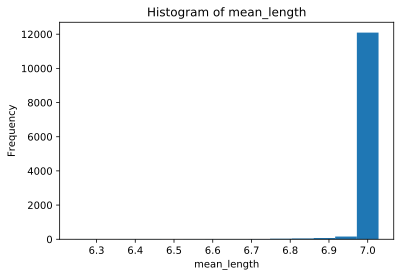

In [16]:
predictions["mean_length"].hist()
# The histogram of the mean_length shows that most tx have a mean_length greater than 6.9. This means that 
# it takes around 7 splits on average to partition them.

## Predicting Anomalies using Quantile
As we formulated this problem in an unsupervised fashion, how do we go from the average number of splits / anomaly score to the actual predictions? Using a threshold! If we have an idea about the relative number of outliers in our dataset, we can find the corresponding quantile value of the score and use it as a threshold for our predictions.

In [17]:
quantile = 0.95
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs,predictQuantiles,mean_lengthQuantiles
0.95,0.091954,7


In [19]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["class"] = test_h2o["Response_int"]
predictions.head()

predict,mean_length,predicted_class,class
0.0689655,6.94,0,0
0.0114943,6.99,0,0
0,7,0,0
0,7,0,0
0.045977,6.96,0,0
0.0344828,6.97,0,0
0,7,0,0
0,7,0,0
0,7,0,0
0,7,0,0


In [50]:
h2o_predictions = predictions.as_data_frame()


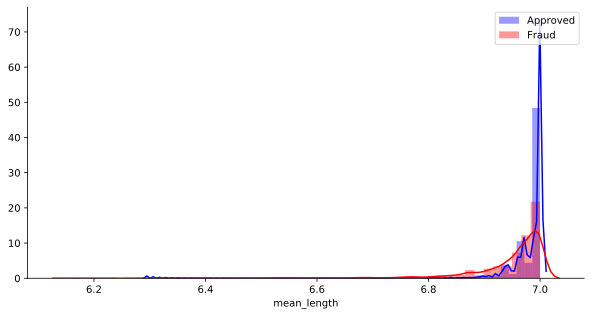

In [73]:
fig = plt.figure(figsize = (10,5))
sns.distplot(h2o_predictions.loc[h2o_predictions["class"]==0,'mean_length'] , color="blue", label="Approved")
sns.distplot(h2o_predictions.loc[h2o_predictions["class"]==1,'mean_length'] , color="red", label="Fraud")
plt.legend(loc='upper right')
sns.despine();
# frauds have slightly shorter path lengths than approved.

In [53]:
n_errors = (iso_sk_pred_df['predicted_class'] != iso_sk_pred_df["class"]).sum()
# Run Classification Metrics
print(f"h2o Isolation forest: {n_errors}")

print("Accuracy Score: {:6.4f}".format(accuracy_score(h2o_predictions["class"],h2o_predictions['predicted_class'])))

print("\n")
print("Classification Report :")
print("Default threshold:")
print(metrics.classification_report(h2o_predictions["class"],h2o_predictions['predicted_class']))

print("ROC AUC score = ", roc_auc_score(h2o_predictions["class"],h2o_predictions['predicted_class']))
print("RF Test confusion matrix: \n\n", confusion_matrix(h2o_predictions["class"],h2o_predictions['predicted_class']))

print("\n")
print("Log-loss: {:6.4f}".format(log_loss(h2o_predictions["class"],h2o_predictions['predicted_class'])))


h2o Isolation forest: 1248
Accuracy Score: 0.9014


Classification Report :
Default threshold:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11372
           1       0.35      0.19      0.25      1058

    accuracy                           0.90     12430
   macro avg       0.64      0.58      0.60     12430
weighted avg       0.88      0.90      0.89     12430

ROC AUC score =  0.5804809777206245
RF Test confusion matrix: 

 [[10999   373]
 [  853   205]]


Log-loss: 3.4067


## Sklearn

In [33]:
# Select Columns that ends with label_encoded
sklearn_X = df2.filter(regex='label_encoded$',axis=1).columns.tolist()
sklearn_X.extend(['Refused', 'Amt', 'Bin', 'Hour'])


In [34]:
sklearn_X

['CompanyAccount_label_encoded',
 'MerchantAccount_label_encoded',
 'CurrencyCode_label_encoded',
 'Scheme_label_encoded',
 'PaymentMethodVariant_label_encoded',
 'IssuerCountryCode_label_encoded',
 'ShopperCountryCode_label_encoded',
 'MerchantCountryCode_label_encoded',
 'Refused',
 'Amt',
 'Bin',
 'Hour']

In [35]:
# contamination = % of outliers
train_df['Response_int'].value_counts()[1]/train_df['Response_int'].value_counts()[0]
df2['Response_int'].value_counts()[1]/df2['Response_int'].value_counts()[0]

0.08564440756430973

0.0871147185389917

In [36]:
from sklearn.ensemble import IsolationForest
iso_sk_random = IsolationForest(contamination=float(.08), max_features=1.0, bootstrap=True,
                                               max_samples = 0.1, n_estimators = 100)
iso_sk_random.fit(train_df[sklearn_X])
iso_sk_pred = iso_sk_random.predict(test_df[sklearn_X])
iso_sk_score = iso_sk_random.score_samples(test_df[sklearn_X])

iso_sk_pred_df = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_sk_pred)),
    "class": test_df['Response_int'],
    "predict": -iso_sk_score
})

iso_sk_pred_df.head()


/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=True, contamination=0.08,
                max_features=1.0, max_samples=0.1, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


,predicted_class,class,predict
5644,0,0,0.50
54437,0,0,0.47
22587,0,0,0.39
19018,0,0,0.40
2765,0,0,0.52


In [49]:
n_errors = (iso_sk_pred_df['predicted_class'] != iso_sk_pred_df["class"]).sum()
# Run Classification Metrics
print(f"sklearn Isolation forest: {n_errors}")

print("Accuracy Score: {:6.4f}".format(accuracy_score(iso_sk_pred_df["class"],iso_sk_pred_df['predicted_class'])))

print("\n")
print("Classification Report :")
print("Default threshold:")
print(metrics.classification_report(iso_sk_pred_df["class"],iso_sk_pred_df['predicted_class']))

print("ROC AUC score = ", roc_auc_score(iso_sk_pred_df["class"],iso_sk_pred_df['predicted_class']))
print("RF Test confusion matrix: \n\n", confusion_matrix(iso_sk_pred_df["class"],iso_sk_pred_df['predicted_class']))

print("\n")
print("Log-loss: {:6.4f}".format(log_loss(iso_sk_pred_df["class"],iso_sk_pred_df['predicted_class'])))

sklearn Isolation forest: 1248
Accuracy Score: 0.8996


Classification Report :
Default threshold:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     11372
           1       0.40      0.38      0.39      1058

    accuracy                           0.90     12430
   macro avg       0.67      0.66      0.67     12430
weighted avg       0.90      0.90      0.90     12430

ROC AUC score =  0.6626663871798674
RF Test confusion matrix: 

 [[10783   589]
 [  659   399]]


Log-loss: 3.4678


#### sklearn isolation forest has better model performance than h2o's, in terms of higher precision, recall 

### Evaluation
Because the isolation forest is an unsupervised method, it makes sense to have a look at the classification metrics that are not dependent on the prediction threshold and give an estimate of the quality of scoring. Two such metrics are Area Under the Receiver Operating Characteristic Curve (AUC) and Area under the Precision-Recall Curve (AUCPR).

AUC is a metric evaluating how well a binary classification model distinguishes true positives from false positives. The perfect AUC score is 1; the baseline score of a random guessing is 0.5.

AUCPR is a metric evaluating the precision recall trade-off of a binary classification using different thresholds of the continuous prediction score. The perfect AUCPR score is 1; the baseline score is the relative count of the positive class.

For highly imbalanced data, AUCPR is recommended over AUC as the AUCPR is more sensitive to True positives, False positives and False negatives, while not caring about True negatives, which in large quantity usually overshadow the effect of other metrics.

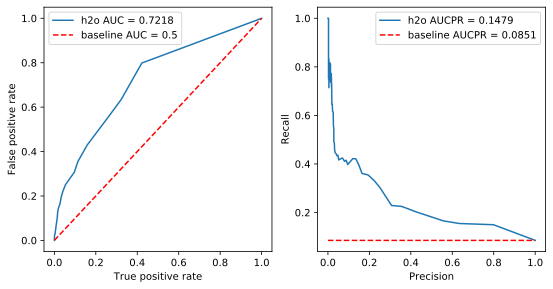

In [59]:
def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score
def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score
def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)
def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")
    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")
    plt.show()
    return axes
def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)
h2o_predictions = predictions.as_data_frame()
figure()
axes = prediction_summary(
    h2o_predictions["class"], h2o_predictions["predict"], "h2o")

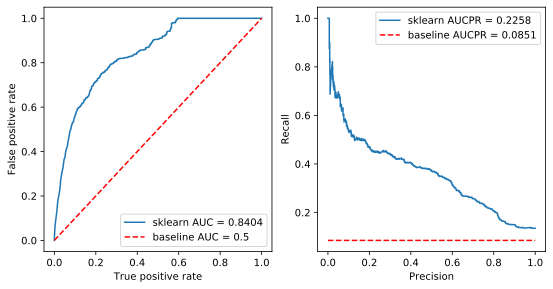

In [60]:
figure()
axes = prediction_summary(
    iso_sk_pred_df["class"], iso_sk_pred_df["predict"], "sklearn")

### More Robust Comparison
Because there is a lot of randomness in the isolation forests training, we will train the isolation forest 20 times for each library using different seeds, and then we will compare the statistics. While 20 times might not be enough, it could give us some insight into how the isolation forests perform on our anomaly detection task.

In [70]:
from tqdm import tqdm_notebook


def stability_check(train_predict_fn, x, y, ntimes=20):
    scores = ["AUC", "AUCPR"]
    scores = {key: [] for key in scores}
    seeds = np.linspace(1, (2**32) - 1, ntimes).astype(int)
    for seed in tqdm_notebook(seeds):
        predictions = train_predict_fn(x, int(seed))
        _, _, auc_score = get_auc(y, predictions)
        _, _, aucpr_score = get_aucpr(y, predictions)

        scores["AUC"].append(auc_score)
        scores["AUCPR"].append(aucpr_score)

    return pd.DataFrame(scores)


def iso_forests_h2o(data,seed):
    isoforest = h2o.estimators.H2OIsolationForestEstimator(sample_rate = 0.1,categorical_encoding='Enum',
        ntrees=ntrees, seed=seed)
    isoforest.train(x=X, training_frame=train_h2o)
    preds = isoforest.predict(test_h2o)
    return preds.as_data_frame()["predict"]



def iso_forests_sklearn(data,seed):
    iso = IsolationForest(random_state=seed, n_estimators=ntrees, max_features=1.0, bootstrap=True,
                         max_samples = 0.1,contamination=float(.08))
    iso.fit(train_df[sklearn_X])
    iso_score = iso.score_samples(test_df[sklearn_X])
    return -iso_score

h2o.no_progress()

h2o_check = stability_check(iso_forests_h2o, X, h2o_predictions["class"])
sklearn_check = stability_check(
    iso_forests_sklearn, train_df, iso_sk_pred_df["class"])

sklearn_check.join(h2o_check, rsuffix="_h2o", lsuffix="_sklearn").describe()


/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'IssuerCountryCode' has levels not trained on: [MT]
  warnings.warn(w)
/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'ShopperCountryCode' has levels not trained on: [MT, PE]
  warnings.warn(w)


/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/admin/anaconda3/envs/metis/lib/python3.7/site-packages/sklea

,AUC_sklearn,AUCPR_sklearn,AUC_h2o,AUCPR_h2o
count,20.00,20.00,20.00,20.00
mean,0.85,0.23,0.74,0.18
std,0.01,0.01,0.06,0.05
min,0.83,0.20,0.64,0.12
25%,0.84,0.22,0.71,0.15
50%,0.84,0.23,0.73,0.16
75%,0.85,0.24,0.76,0.20
max,0.87,0.26,0.87,0.32


### Comparison Results
Looking at the results of the 20 runs, we can see that on average, scikit-learn implementation in both AUC and AUCPR is higher than the h2o isolation forest implementation.

